In [3]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

import torch

c:\ProgramData\Anaconda3\envs\torch_cuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

print("Setup Complete")

Setup Complete


Feature Extraction and Extension CODE: https://github.com/min0355/ai-novatus/blob/main/PBL%20main%20code/No.3_Feature%20selection%20and%20Feature%20Extension.ipynb

In [5]:
df = pd.read_csv(r'./sensor04_pre_sensor.csv')
df.head(1)

FileNotFoundError: [Errno 2] No such file or directory: './pre_sensor.csv'

In [4]:
def make_df(df):
    
    label_mapping = {
    0.0: 1, # normal
    0.5: 2, # recovering
    1: 0  # broken
    }
    
    del df['Unnamed: 0']
    df.loc[:, "operation"] = df.operation.map(label_mapping) 
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    feature = [
    f for f in df.columns if f in ("sensor_04", "operation")
    ]
    return df[feature]

In [5]:
df = make_df(df)
df.head()

,sensor_04,operation
timestamp,,
2018-04-01 00:00:00,0.792242,1
2018-04-01 00:01:00,0.792242,1
2018-04-01 00:02:00,0.797904,1
2018-04-01 00:03:00,0.784402,1
2018-04-01 00:04:00,0.794855,1


In [6]:
df['operation'].nunique()

3

In [7]:
labels = np.where(df['operation'] == 0, 0, 1)
labels

array([1, 1, 1, ..., 1, 1, 1])

In [8]:
labels.size

220320

## LSTM (check another kernel) 

In [9]:
normal_x = df[labels == 1] # normal or recovering
anomaly_x = df[labels == 0] # broken 

normal_y = labels[labels == 1]
anomaly_y = labels[labels == 0]

In [10]:
print(normal_x.shape)
print(normal_y.shape)
print(anomaly_x.shape)
print(anomaly_y.shape)

(220313, 2)
(220313,)
(7, 2)
(7,)


In [11]:
len_normal = len(normal_x)
len_normal_train = int(0.8 * len_normal)
x_train = normal_x[:len_normal_train]

x_test_normal = normal_x[len_normal_train:]
len_anomaly_test = len(x_test_normal)
x_test_anomaly = anomaly_x[:len_anomaly_test]

x_test = np.concatenate([x_test_normal, x_test_anomaly])
y_test = np.ones(len(x_test))
y_test[:len(x_test_normal)] = 0

In [12]:
print(x_train.shape)
print(x_test.shape)

(176250, 2)
(44070, 2)


In [13]:
x_train[x_train['operation'] == 0].count()

sensor_04    0
operation    0
dtype: int64

### define error 

In [14]:
def get_error(s1, s2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((s1 - s2) ** 2, axis=1))
    return np.mean((s1 - s2) ** 2, axis=1)

### the reparameterization trick

In [15]:
def sample(args):
    z_mean, z_log_var =args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [16]:
x_train.shape[1]

2

In [17]:
original_dim = x_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = 2           # original_dim / 2
latent_dim = 1                 # original_dim / 3

In [18]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 2)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 2)            6           ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 1)            3           ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 1)            3           ['dense[0][0]']                  
                                                                                            

In [19]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 1)]               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4         
                                                                 
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [20]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae')

In [21]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [22]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(x_train, x_train,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        epochs=128,
                        batch_size=256)

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 encoder (Functional)        (None, 1)                 12        
                                                                 
 decoder (Functional)        (None, 2)                 10        
                                                                 
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________
Train on 176250 samples, validate on 44070 samples
Epoch 1/128


2022-06-09 21:18:02.814606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 21:18:02.832088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 21:18:02.832245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 21:18:02.832950: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

 27392/176250 [===>..........................] - ETA: 5s - loss: 134.9818

2022-06-09 21:18:03.640790: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


176250/176250 [==============================] - 2s 12us/sample - loss: 129.8074 - val_loss: 80.7213
Epoch 2/128
176250/176250 [==============================] - 1s 7us/sample - loss: 119.4954 - val_loss: 72.7098
Epoch 3/128
176250/176250 [==============================] - 1s 6us/sample - loss: 112.2965 - val_loss: 66.3535
Epoch 4/128
176250/176250 [==============================] - 1s 6us/sample - loss: 106.0945 - val_loss: 60.4702
Epoch 5/128
176250/176250 [==============================] - 1s 6us/sample - loss: 100.2820 - val_loss: 54.9589
Epoch 6/128
176250/176250 [==============================] - 1s 6us/sample - loss: 94.8301 - val_loss: 49.8074
Epoch 7/128
176250/176250 [==============================] - 1s 6us/sample - loss: 89.7469 - val_loss: 45.0083
Epoch 8/128
176250/176250 [==============================] - 1s 7us/sample - loss: 85.0104 - val_loss: 40.5550
Epoch 9/128
176250/176250 [==============================] - 1s 7us/sample - loss: 80.6129 - val_loss: 36.4430
Epoch 1

176250/176250 [==============================] - 1s 6us/sample - loss: 31.4218 - val_loss: 1.2198
Epoch 75/128
176250/176250 [==============================] - 1s 6us/sample - loss: 31.4072 - val_loss: 1.2148
Epoch 76/128
176250/176250 [==============================] - 1s 6us/sample - loss: 31.3889 - val_loss: 1.2163
Epoch 77/128
176250/176250 [==============================] - 1s 6us/sample - loss: 31.3754 - val_loss: 1.2093
Epoch 78/128
176250/176250 [==============================] - 1s 6us/sample - loss: 31.3627 - val_loss: 1.2115
Epoch 79/128
176250/176250 [==============================] - 1s 6us/sample - loss: 31.3442 - val_loss: 1.2125
Epoch 80/128
176250/176250 [==============================] - 1s 6us/sample - loss: 31.3365 - val_loss: 1.1995
Epoch 81/128
176250/176250 [==============================] - 1s 6us/sample - loss: 31.3137 - val_loss: 1.2003
Epoch 82/128
176250/176250 [==============================] - 1s 6us/sample - loss: 31.3079 - val_loss: 1.2041
Epoch 83/128
1

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


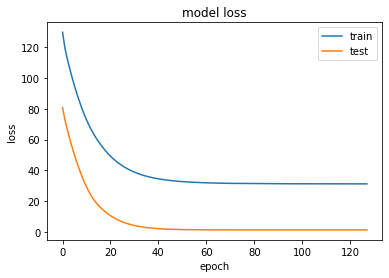

In [23]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [24]:
x_train_pred = vae_model.predict(x_train)

In [25]:
mae_vector = get_error(x_train_pred, x_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\ndataset: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.06100279004266806
median error 0.002329527643844159
dataset: 0.7617207553118484
setting threshold on 0.7617207553118484 


In [26]:
x_pred = vae_model.predict(x_test)
mae_vector = get_error(x_pred, x_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.0

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     44063
         1.0       0.00      0.00      0.00         7

    accuracy                           1.00     44070
   macro avg       0.50      0.50      0.50     44070
weighted avg       1.00      1.00      1.00     44070

